<a href="https://colab.research.google.com/github/anggapark/detect-begomovirus/blob/main/SSD_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 7.0 MB/s eta 0:00:00


In [2]:
import os
import time
import shutil
from glob import glob
from pathlib import Path
from collections import Counter
from xml.etree import ElementTree as ET
from tqdm.notebook import tqdm, trange

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchmetrics
import torchvision
from torchvision.utils import draw_bounding_boxes
import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image, ImageDraw
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

# model
from torchvision import transforms
from torchvision.io import read_image
from torchvision.models.detection import (
    SSDLite320_MobileNet_V3_Large_Weights,
    _utils,
    ssdlite320_mobilenet_v3_large,
)
from torchvision.models.detection.ssd import SSDClassificationHead

# metric
from torchmetrics import Precision, Recall
from torchmetrics.detection.mean_ap import MeanAveragePrecision

import warnings
warnings.filterwarnings("ignore")

In [3]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.1.0+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


# Upload Dataset from Roboflow

In [4]:
# # upload dataset from roboflow (diubah sesuai kebutuhan)
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="UDTU0z0V2s0YrtieNgro")
project = rf.workspace("project-ll4ir").project("ssd_detect_yellow_disease")
dataset = project.version(2).download("voc")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ssd_detect_yellow_disease-2 in voc:: 100%|██████████| 9403/9403 [00:01<00:00, 7776.76it/s]


# Define Path

In [5]:
dataset_path = Path('/content/ssd_detect_yellow_disease-2')

train_data_list = sorted(dataset_path.rglob("train/*"))
val_data_list = sorted(dataset_path.rglob("valid/*"))
test_data_list = sorted(dataset_path.rglob("test/*"))

train_img_path = sorted(dataset_path.rglob("train/*.jpg"))
train_xml_path = sorted(dataset_path.rglob("train/*.xml"))

# img_path_split = sorted(dataset_path.rglob(''))

In [6]:
len(train_data_list), len(val_data_list), len(test_data_list)

(8222, 394, 782)

# Visualize Sample Image

## Define Helper Function

In [7]:
def img_and_xml(path):
    """
    Match image file and xml file based on their filename
    Args:
        path (str): Path from dataset
    Return:
        Tuple (str, str): (string of image file, string of xml file)
    """
    # filename = path[:-4]
    filename = path.stem
    dirname = os.path.dirname(path)

    return (
        os.path.join(dirname, f"{filename}.jpg"),
        os.path.join(dirname, f"{filename}.xml"),
    )


def print_xml(xml_path):
    """
    Read XML files and print it
    Args:
        xml_path (str): Path to xml files
    Return:
        None
    """
    with open(xml_path, "r", encoding="utf-8") as annot:
        print(" ".join(annot.readlines()))


def get_annot_labels(xml_path, ):
    """
    Extracted XML files as annotation that consist
    of bounding boxes coordinates and label name.

    Args:
        xml_files (str): Path to xml files

    Return:
        boxes (list): List of extracted bounding boxes coordnates
        labels (list): List of corresponding label name
    """
    boxes = []
    labels = []

    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Extracted box coordinates for xml files
    #   and corrected for given image size
    for member in root.findall("object"):
        try:
            # Left corner x-coordinates
            xmin = int(member.find("bndbox").find("xmin").text)
            # Right corner x-coordinates
            xmax = int(member.find("bndbox").find("xmax").text)
            # Left corner y-coordinates
            ymin = int(member.find("bndbox").find("ymin").text)
            # Right corner y-coordinates
            ymax = int(member.find("bndbox").find("ymax").text)
            # Get label name
            label = member.find("name").text

            # # Resize the bounding boxes according
            # #   to resized image 'width' and 'height'
            # xmin_final = (xmin / image_width) * self.width
            # xmax_final = (xmax / image_width) * self.width
            # ymin_final = (ymin / image_height) * self.height
            # ymax_final = (ymax / image_height) * self.height

            # # check that all coordinates are within the image
            # if xmax_final > self.width:
            #     xmax_final = self.width
            # if ymax_final > self.height:
            #     ymax_final = self.height
        except:
            continue

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return boxes, labels


def visualize_img_with_bbox(path):
    """
    Visualize sample images with it corresponding bounding box(es).

    Args:
        path (str): Path to files
    Return:
        view_img: Image of data
    """
    img_path, xml_path = img_and_xml(path)

    sample_img = Image.open(img_path)
    sample_annot, sample_label = get_annot_labels(xml_path)

    tensor_img = (transforms.ToTensor()(sample_img) * 255).to(torch.uint8)
    tensor_annot = torch.tensor(sample_annot)

    dict_color = {"positif_begomovirus": "red", "negatif_begomovirus": "blue"}
    colors = [dict_color[x] for x in sample_label]
    img = draw_bounding_boxes(
        tensor_img, boxes=tensor_annot, labels=sample_label, width=3, colors=colors
    )

    img_filename = os.path.basename(img_path)
    annot_filename = os.path.basename(xml_path)
    print(f"image: {img_filename}")
    print(f"annot: {annot_filename}")
    view_img = transforms.ToPILImage()(img)

    return view_img

## Apply Functions

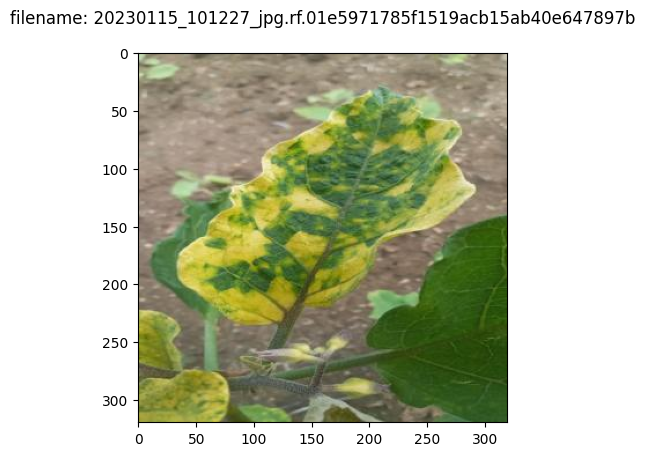

In [8]:
# sample_img = Image.open(img_path[0])
# sample_img.show()

sample = plt.imread(train_img_path[0])

plt.title(f"filename: {train_img_path[0].stem}\n")
plt.imshow(sample)

In [9]:
print_xml(train_xml_path[0])

<annotation>
 	<folder></folder>
 	<filename>20230115_101227_jpg.rf.01e5971785f1519acb15ab40e647897b.jpg</filename>
 	<path>20230115_101227_jpg.rf.01e5971785f1519acb15ab40e647897b.jpg</path>
 	<source>
 		<database>roboflow.com</database>
 	</source>
 	<size>
 		<width>320</width>
 		<height>320</height>
 		<depth>3</depth>
 	</size>
 	<segmented>0</segmented>
 	<object>
 		<name>positif_begomovirus</name>
 		<pose>Unspecified</pose>
 		<truncated>0</truncated>
 		<difficult>0</difficult>
 		<occluded>0</occluded>
 		<bndbox>
 			<xmin>36</xmin>
 			<xmax>296</xmax>
 			<ymin>27</ymin>
 			<ymax>240</ymax>
 		</bndbox>
 	</object>
 </annotation>



In [10]:
get_annot_labels(train_xml_path[0])

([[36, 27, 296, 240]], ['positif_begomovirus'])

image: 20230115_101227_jpg.rf.01e5971785f1519acb15ab40e647897b.jpg
annot: 20230115_101227_jpg.rf.01e5971785f1519acb15ab40e647897b.xml


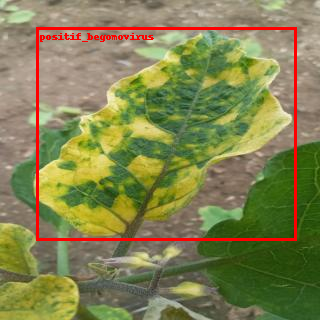

In [11]:
visualize_img_with_bbox(train_data_list[0])

# K-Fold Cross Validation

## Prepare Dataframe

In [12]:
class_names = ["negatif_begomovirus", "positif_begomovirus"]
idx = {i: item for i, item in enumerate(class_names)}
class_idx = sorted(idx.keys())

In [13]:
# get data from each dataset split
data_splits = ["train", "valid"]

# Initialize an empty list to store image and label file paths
images = []
labels = []

# Loop through data splits and gather the files
for s in tqdm(data_splits):
    images.extend(sorted(dataset_path.rglob(f"{s}/*.jpg")))
    labels.extend(sorted(dataset_path.rglob(f"{s}/*.xml")))

  0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
len(images), len(labels)

(4308, 4308)

In [15]:
# initialize empty pandas dataframe
import pandas as pd

indx = [l.stem for l in labels]
labels_df = pd.DataFrame([], columns=class_names, index=indx)

In [16]:
labels_df

,negatif_begomovirus,positif_begomovirus
20230115_101227_jpg.rf.01e5971785f1519acb15ab40e647897b,NaN,NaN
20230115_101227_jpg.rf.29e6fd11b53799b73d23876f4466dadd,NaN,NaN
20230115_101227_jpg.rf.da956c2d6254d12d0222d9fbc4d7cf80,NaN,NaN
20230115_101343_jpg.rf.5f9f4e947264c57781ea6f03c32501bb,NaN,NaN
20230115_101343_jpg.rf.8a2184c9b5a54bdef382e1e5b9c5e3fc,NaN,NaN
...,...,...
Screenshot-2023-10-25-122008_png.rf.425c16d5cd42964b6e1712798e97e585,NaN,NaN
Screenshot-2023-10-25-122026_png.rf.fd0c56169238943c26822d47d70336ef,NaN,NaN
Screenshot-2023-10-25-122039_png.rf.d5c4c65345d0c1827261d768f45c4c66,NaN,NaN
Screenshot-2023-10-25-122050_png.rf.b1aee004185f5156343f81cf8928a082,NaN,NaN


In [17]:
# Count the instances of each class-label present in the annotation files
for label in labels:
    label_counter = Counter()
    tree = ET.parse(label)
    root = tree.getroot()

    labelname = [member.find("name").text for member in root.findall("object")]

    label_counter.update(labelname)

    # print(label_counter)

    labels_df.loc[label.stem] = label_counter

labels_df = labels_df.fillna(0.0)

In [18]:
# sample view of the populated DataFrame
labels_df

,negatif_begomovirus,positif_begomovirus
20230115_101227_jpg.rf.01e5971785f1519acb15ab40e647897b,0.0,1.0
20230115_101227_jpg.rf.29e6fd11b53799b73d23876f4466dadd,0.0,1.0
20230115_101227_jpg.rf.da956c2d6254d12d0222d9fbc4d7cf80,0.0,1.0
20230115_101343_jpg.rf.5f9f4e947264c57781ea6f03c32501bb,0.0,1.0
20230115_101343_jpg.rf.8a2184c9b5a54bdef382e1e5b9c5e3fc,0.0,1.0
...,...,...
Screenshot-2023-10-25-122008_png.rf.425c16d5cd42964b6e1712798e97e585,1.0,0.0
Screenshot-2023-10-25-122026_png.rf.fd0c56169238943c26822d47d70336ef,1.0,0.0
Screenshot-2023-10-25-122039_png.rf.d5c4c65345d0c1827261d768f45c4c66,1.0,0.0
Screenshot-2023-10-25-122050_png.rf.b1aee004185f5156343f81cf8928a082,1.0,0.0


<BarContainer object of 2 artists>

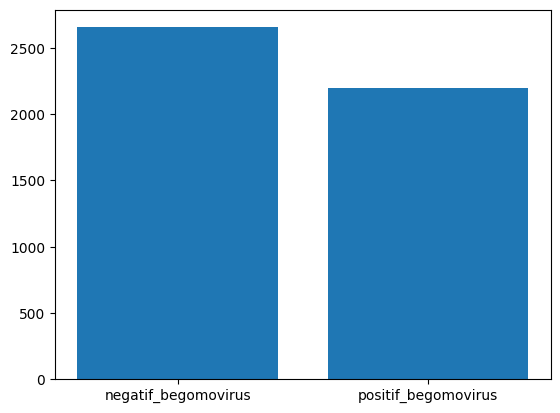

In [19]:
# Visualize the sum of instances of each class-label present in the annotation files
col_sum = labels_df.sum(axis=0)
plt.bar(col_sum.index, col_sum.values)

In [20]:
col_sum.values

array([2657., 2195.])

## Perform Cross Val

In [21]:
# initialize K-Fold cross validation with k=5
from sklearn.model_selection import KFold

ksplit = 5
kf = KFold(
    n_splits=ksplit, shuffle=True, random_state=42
)  # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [22]:
# separate each split
folds = [f"fold_{n}" for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

# fill df values with train and val split
for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f"fold_{idx}"].loc[labels_df.iloc[train].index] = "train"
    folds_df[f"fold_{idx}"].loc[labels_df.iloc[val].index] = "val"

In [23]:
folds_df

,fold_1,fold_2,fold_3,fold_4,fold_5
20230115_101227_jpg.rf.01e5971785f1519acb15ab40e647897b,train,val,train,train,train
20230115_101227_jpg.rf.29e6fd11b53799b73d23876f4466dadd,train,train,val,train,train
20230115_101227_jpg.rf.da956c2d6254d12d0222d9fbc4d7cf80,train,train,train,val,train
20230115_101343_jpg.rf.5f9f4e947264c57781ea6f03c32501bb,train,train,train,val,train
20230115_101343_jpg.rf.8a2184c9b5a54bdef382e1e5b9c5e3fc,train,train,train,train,val
...,...,...,...,...,...
Screenshot-2023-10-25-122008_png.rf.425c16d5cd42964b6e1712798e97e585,train,train,train,train,val
Screenshot-2023-10-25-122026_png.rf.fd0c56169238943c26822d47d70336ef,train,train,val,train,train
Screenshot-2023-10-25-122039_png.rf.d5c4c65345d0c1827261d768f45c4c66,train,train,val,train,train
Screenshot-2023-10-25-122050_png.rf.b1aee004185f5156343f81cf8928a082,val,train,train,train,train


In [24]:
folds_df['fold_2'].value_counts()

train    3446
val       862
Name: fold_2, dtype: int64

In [25]:
# get label distribution in each fold
fold_lbl_distrb = pd.DataFrame(index=folds, columns=class_names)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1e-7)
    fold_lbl_distrb.loc[f"fold_{n}"] = ratio

In [26]:
fold_lbl_distrb

,negatif_begomovirus,positif_begomovirus
fold_1,0.246248,0.261494
fold_2,0.261633,0.224205
fold_3,0.251531,0.254286
fold_4,0.247418,0.258601
fold_5,0.243332,0.252139


In [27]:
# Create the necessary directories
save_path = Path(dataset_path / f"{ksplit}-Fold_Cross-val")
save_path.mkdir(parents=True, exist_ok=True)

for split in tqdm(folds_df.columns):
    # Create directories
    fold_dir = save_path / split
    fold_dir.mkdir(parents=True, exist_ok=True)
    (fold_dir / "train").mkdir(parents=True, exist_ok=True)
    (fold_dir / "val").mkdir(parents=True, exist_ok=True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [28]:
# fill the directories with data according to the structure in folds_df dataframe
for image, label in tqdm(zip(images, labels)):
    for split, fold in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / fold
        lbl_to_path = save_path / split / fold

        # Copy image and label files to new directory
        #   (SamefileError if file already exists)
        shutil.copy(image, img_to_path)
        shutil.copy(label, lbl_to_path)

0it [00:00, ?it/s]

In [29]:
def check_unmatched_filename(k, data_split):
    """
    Check each fold to make sure images in each
    split has its own corresponding annotation.
    Args:
        k (int): K-split numbers (1-5)
        data_split (str): Train or validation split
    Return:
        None
    """
    kfold_paths = Path('/content/ssd_detect_y|ellow_disease-2/5-Fold_Cross-val')

    # Collect img files and annotation files
    img_files = sorted(kfold_paths.rglob(f"fold_{k}/{data_split}/*.jpg"))
    xml_files = sorted(kfold_paths.rglob(f"fold_{k}/{data_split}/*.xml"))

    unmatched_files = []

    # iterate through images list and find
    #   if there is lone images in one folder
    for img_file in img_files:
        match_xml = img_file.stem + '.xml'
        if match_xml not in xml_files:
            unmatched_files.append(match_xml)

    # iterate through images list and find
    #   if there is lone annotaion in one folder
    for xml_file in xml_files:
        match_img = xml_file.stem + '.jpg'
        if match_img not in img_files:
            unmatched_files.append(match_img)

    if unmatched_files:
        print(f"Unmatched files found in fold_{k}:")
        for file in unmatched_files:
            print(file)
    else:
        print("All files have matching counterparts.")

In [30]:
for k in range(1, 6):
    print(f'fold: {k}')
    check_unmatched_filename(k, train)
    check_unmatched_filename(k, val)

fold: 1
All files have matching counterparts.
All files have matching counterparts.
fold: 2
All files have matching counterparts.
All files have matching counterparts.
fold: 3
All files have matching counterparts.
All files have matching counterparts.
fold: 4
All files have matching counterparts.
All files have matching counterparts.
fold: 5
All files have matching counterparts.
All files have matching counterparts.


In [31]:
kfold_paths = Path('/content/ssd_detect_yellow_disease-2/5-Fold_Cross-val')
train_files = sorted(kfold_paths.rglob(f"fold_1/train/*"))
len(train_files)

6892

# Model Building

## Set Utilities

In [32]:
plt.style.use("ggplot")


class Averager:
    """
    keep track of the training and validation loss values
    and helps to get the average for each epochs
    """

    # define initial values and iterations
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


class SaveBestModel:
    """
    Save the best model while training. If the current epoch's
    validation mAP @0.5:0.95 IoU higher than the previous highest,
    then save the model
    """

    def __init__(self, best_valid_map=float(0)):
        self.best_valid_map = best_valid_map

    def __call__(self, model, current_valid_map, epoch, OUTPUT_DIR, k=None):
        if current_valid_map > self.best_valid_map:
            self.best_valid_map = current_valid_map
            print(f"\nBest Validation mAP: {self.best_valid_map}\n")
            print(f"Saving Best Model for Epoch: {epoch + 1}")
            if k:
                torch.save(
                    {
                        "epoch": epoch + 1,
                        "model_state_dict": model.state_dict(),
                    },
                    f"{OUTPUT_DIR}/best_model_{k}.pt",
                )
            else:
                torch.save(
                    {
                        "epoch": epoch + 1,
                        "model_state_dict": model.state_dict(),
                    },
                    f"{OUTPUT_DIR}/best_model.pt",
                )

In [33]:
def collate_fn(batch):
    """
    Handle the data loading as different images may have
    different numbers of objects and to handle varying size tensors
    """
    return tuple(zip(*batch))


def get_transform():
    """
    Apply transformation for image data

    Returns:
        _type_: _description_
    """
    return A.Compose(
        [
            ToTensorV2(p=1.0),
        ],
        bbox_params={"format": "pascal_voc", "label_fields": ["labels"]},
    )


def save_model(epoch, model, optimizer, k=None):
    """
    save the trained model until current epochs

    Args:
        epochs (int): path to save the graphs
        model: weight model after training
        optimizer: optimizer used for model training
    """
    if k:
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            f"outputs/model_{k}.pt",
        )
    else:
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            "outputs/model.pt",
        )



def save_loss_plot(
    OUTPUT_DIR,
    train_loss_list,
    x_label="iterations",
    y_label="train_loss",
    k=None
):
    """
    save loss graph through epochs

    Args:
        OUTPUT_DIR: Path to save the graphs.
        train_loss_list: List containing the training loss values.
    """
    fig_1 = plt.figure(figsize=(10, 7), num=1, clear=True)
    train_ax = fig_1.add_subplot()

    train_ax.plot(train_loss_list, color="tab:blue")
    train_ax.set_xlabel(x_label)
    train_ax.set_ylabel(y_label)
    if k:
        fig_1.savefig(f"{OUTPUT_DIR}/train_loss_fold{k}")
    else:
        fig_1.savefig(f"{OUTPUT_DIR}/train_loss")
    # print("Saving Plots Complete...")


def save_precision(OUTPUT_DIR, precision, k=None):
    pass


def save_recall(OUTPUT_DIR, recall, k=None):
    pass


def save_mAP(OUTPUT_DIR, mAP_05, mAP_05_095, k=None):
    """
    save the mAP@0.5 and mAP@0.5:0.95 through epochs.

    Args:
        OUTPUT_DIR (str): path to save the graphs
        mAP_05 (list): list containing mAP values at 0.5 IoU
        mAP (list): list containing mAP values at 0.5:0.95 IoU
    """
    fig = plt.figure(figsize=(10, 7), num=1, clear=True)
    ax = fig.add_subplot()

    ax.plot(mAP_05, color="tab:orange", linestyle="-", label="mAP@0.5")
    ax.plot(mAP_05_095, color="tab:red", linestyle="-", label="mAP@0.5:0.95")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("mAP")
    ax.legend()
    if k:
        fig.savefig(f"{OUTPUT_DIR}/mAP_fold{k}.png")
    else:
        fig.savefig(f"{OUTPUT_DIR}/mAP.png")

## Datasets

In [34]:
# The dataset class.
class CustomDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        self.image_file_types = ["*.jpg", "*.jpeg", "*.png", "*.ppm", "*.JPG"]
        self.all_image_paths = []

        # get all the image path in sorted order
        for file_type in self.image_file_types:
            if file_type in self.image_file_types:
                self.all_image_paths.extend(
                    glob(os.path.join(self.dir_path, file_type))
                )

        self.all_images = [
            image_path.split(os.path.sep)[-1] for image_path in self.all_image_paths
        ]
        self.all_images = sorted(self.all_images)

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        # get the image name and its full path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        # Read and preprocess the image.
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0

        # get corresponding XML file for the annotation
        annot_filename = os.path.splitext(image_name)[0] + ".xml"
        annot_file_path = os.path.join(self.dir_path, annot_filename)

        boxes = []
        labels = []
        tree = ET.parse(annot_file_path)
        root = tree.getroot()

        # original image width and height
        image_width = image.shape[1]
        image_height = image.shape[0]

        # box coordinates for xml files are extracted
        #   and corrected for given image size
        for member in root.findall("object"):
            # get label and map the 'classes'
            labels.append(self.classes.index(member.find("name").text))

            # Left corner x-coordinates.
            xmin = int(member.find("bndbox").find("xmin").text)
            # Right corner x-coordinates.
            xmax = int(member.find("bndbox").find("xmax").text)
            # Left corner y-coordinates.
            ymin = int(member.find("bndbox").find("ymin").text)
            # Right corner y-coordinates.
            ymax = int(member.find("bndbox").find("ymax").text)

            # Resize the bounding boxes according
            #   to resized image 'width' and 'height'
            xmin_final = (xmin / image_width) * self.width
            xmax_final = (xmax / image_width) * self.width
            ymin_final = (ymin / image_height) * self.height
            ymax_final = (ymax / image_height) * self.height

            # check that all coordinates are within the image
            if xmax_final > self.width:
                xmax_final = self.width
            if ymax_final > self.height:
                ymax_final = self.height

            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])

        # bounding bo to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # area of bounding box
        area = (
            (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            if len(boxes) > 0
            else torch.as_tensor(boxes, dtype=torch.float32)
        )

        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final target dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # apply the image transforms
        if self.transforms:
            sample = self.transforms(
                image=image_resized, bboxes=target["boxes"], labels=labels
            )
            image_resized = sample["image"]
            target["boxes"] = torch.Tensor(sample["bboxes"])

        if np.isnan((target["boxes"]).numpy()).any() or target[
            "boxes"
        ].shape == torch.Size([0]):
            target["boxes"] = torch.zeros((0, 4), dtype=torch.int64)

        return image_resized, target

In [35]:
# prepare the final datasets and data loaders
def create_train_dataset(dir, width, height, classes):
    train_dataset = CustomDataset(dir, width, height, classes, get_transform())

    return train_dataset


def create_valid_dataset(dir, width, height, classes):
    valid_dataset = CustomDataset(dir, width, height, classes, get_transform())

    return valid_dataset


def create_train_loader(train_dataset, batch_size, num_workers=0):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=True,
    )

    return train_loader


def create_valid_loader(valid_dataset, batch_size, num_workers=0):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=True,
    )

    return valid_loader

## Build Model

In [36]:
def create_model(num_classes, size=320):
    # load torchvision pretrained model
    model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(
        weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1
    )

    # Retrieve the list of input channel
    in_channel = _utils.retrieve_out_channels(model.backbone, (size, size))

    # list containing number of anchors based on aspect ratio
    num_anchors = model.anchor_generator.num_anchors_per_location()

    # classification head
    model.head.classification_head = SSDClassificationHead(
        in_channels=in_channel, num_anchors=num_anchors, num_classes=num_classes
    )

    # images size to transform
    model.transform.min_size = (size,)
    model.transform.max_size = size

    # print(model)

    # total params and trainable params
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters")

    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad
    )
    print(f"{total_trainable_params:,} training parameters")

    return model

## Train Model

In [37]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


# running training iteration
def train_step(train_loader, model, train_loss_hist, optimizer):
    """
    Train a pytorch model for a single epoch

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
        train_loader (torch.utils.data.DataLoader): _description_
        model (torch.nn.Module): _description_
        train_loss_hist (List):
        optimizer (torch.optim.Optimizer):

    Returns:
        loss_value (float32): _description_
    """
    print("Training!")
    model.train()

    # initialize progress bar
    progress_bar = tqdm(train_loader, total=len(train_loader))

    for i, data in enumerate(progress_bar):
        images, targets = data

        # send data to target device
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        # forward pass
        loss_dict = model(images, targets)

        # calculate and accumulate loss
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_hist.send(loss_value)

        # zero grad
        optimizer.zero_grad()

        # loss backward
        losses.backward()

        # optimizer step
        optimizer.step()

        # update the loss value beside the progress bar for each iter
        progress_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return loss_value


# running validation iterations
def validate_step(valid_loader, model):
    """
    Validate pytorch model for a single epoch

    Turns a target PyTorch model to "inference" mode and
    then performs a forward pass on a validating dataset.

    Args:
        valid_loader (torch.utils.data.Dataloader): A valid dataloader instance for the model to be validate on
        model (torch.nn.Module): A pytorch model to be validate

    Returns:
        metric_summary (Dict): A dictionary of metric summary consist of prediction results and ground truth
    """
    print("Validating!")
    model.eval()

    # initialize progress bar
    progress_bar = tqdm(valid_loader, total=len(valid_loader))
    target = []
    preds = []

    for i, data in enumerate(progress_bar):
        images, targets = data

        # send data to device
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.inference_mode():
            outputs = model(images, targets)

            ## mAP calculation using Torchmetrics
            for i in range(len(images)):
                true_dict = dict()
                preds_dict = dict()

                true_dict["boxes"] = targets[i]["boxes"].detach().cpu()
                true_dict["labels"] = targets[i]["labels"].detach().cpu()
                preds_dict["boxes"] = outputs[i]["boxes"].detach().cpu()
                preds_dict["scores"] = outputs[i]["scores"].detach().cpu()
                preds_dict["labels"] = outputs[i]["labels"].detach().cpu()
                preds.append(preds_dict)
                target.append(true_dict)

            metric = MeanAveragePrecision()
            metric.update(preds, target)
            metric_summary = metric.compute()

    return metric_summary

In [38]:
def train(model, train_loader, valid_loader, optimizer, epochs, k=None):
    """
    Train and test a PyTorch model

    Passed a target model through train_step and validation_stap
    functions for the number of epochs, training and validating
    the model in the same loop.

    Calculated

    Args:
        model (torch.nn.Module): A PyTorch model used for training data
        train_loader (torch.utils.data.Dataloader): A train dataloader instance for the model to be trained on
        valid_loader (torch.utils.data.Dataloader): A valid dataloader instance for the model to be validate on
        optimizer (torch.optim.Optimizer): _description_
    Return:
        None
    """
    # monitor training loss
    train_loss_hist = Averager()

    # store training loss and mAP values
    train_loss_list = []
    map_50_list = []
    map_list = []
    # precision_list = []
    # recall_list = []

    # initiate precision and recall
    # precision = Precision(num_class=NUM_CLASSES)

    # name the model
    MODEL_NAME = "model"

    # save best model
    save_best_model = SaveBestModel()

    # train loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1} of {epochs}")

        # reset the training loss histories for the current epoch
        train_loss_hist.reset()

        # start timer and carry out training and validation
        start = time.time()
        train_loss = train_step(train_loader, model, train_loss_hist, optimizer)
        metric_summary = validate_step(valid_loader, model)

        print(
            f"Epoch #{epoch+1}\ntrain loss: {train_loss_hist.value:.3f} | mAP: {metric_summary['map']}"
        )

        # end timer and show training duration
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")

        # collect train result
        train_loss_list.append(train_loss)
        map_50_list.append(metric_summary["map_50"])
        map_list.append(metric_summary["map"])

        # save the best model
        save_best_model(model, float(metric_summary["map"]), epoch, "outputs")
        # save the current epoch model
        save_model(epoch, model, optimizer)

        # add fold to filename if k is not None
        if k:
            # save loss plot
            save_loss_plot(OUTPUT_DIR, train_loss_list, k=k)
            # save mAP plot
            save_mAP(OUTPUT_DIR, map_50_list, map_list, k=k)
        else:
            # save loss plot
            save_loss_plot(OUTPUT_DIR, train_loss_list)
            # save mAP plot
            save_mAP(OUTPUT_DIR, map_50_list, map_list)

        scheduler.step()

## Set Parameters

In [39]:
BATCH_SIZE = 32
IMG_SIZE = 320  # according to ssdlite320_mobilenet_v3_large model docs
NUM_EPOCHS = 20
NUM_WORKERS = 4

# use cuda if GPU is available, else use CPU
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# define cross val dataset path
DATA_PATH = Path("/content/ssd_detect_yellow_disease-2/5-Fold_Cross-val")
TEST_DIR = Path("/content/ssd_detect_yellow_disease-2/test")

CLASSES = ["negatif_begomovirus", "positif_begomovirus"]

NUM_CLASSES = len(CLASSES)

VISUALIZE_TRANSFORMED_IMGS = False

# location to save training outputs
OUTPUT_DIR = "outputs"

## Apply Kfold during training

In [ ]:
os.makedirs("outputs", exist_ok=True)

for k in range(1, ksplit+1):

    TRAIN_DIR = os.path.join(DATA_PATH, f'fold_{k}', 'train')
    VALID_DIR = os.path.join(DATA_PATH, f'fold_{k}', 'val')

    train_dataset = create_train_dataset(dir=TRAIN_DIR,
                                         width=IMG_SIZE,
                                         height=IMG_SIZE,
                                         classes=CLASSES)
    valid_dataset = create_valid_dataset(dir=VALID_DIR,
                                       width=IMG_SIZE,
                                       height=IMG_SIZE,
                                       classes=CLASSES)
    train_loader = create_train_loader(train_dataset,
                                       batch_size=BATCH_SIZE,
                                       num_workers=NUM_WORKERS)
    valid_loader = create_valid_loader(valid_dataset,
                                       batch_size=BATCH_SIZE,
                                       num_workers=NUM_WORKERS)

    # initialize the model
    model = create_model(num_classes=NUM_CLASSES, size=IMG_SIZE)
    model = model.to(DEVICE)

    # show model architecture only once
    if k == 1:
        print(f"Number of training samples: {len(train_dataset)}")
        print(f"Number of validation samples: {len(valid_loader)}")
        print('Model:')
        print(model)
        print('\n')

    params = [p for p in model.parameters() if p.requires_grad]

    # optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True)
    OPTIMIZER = torch.optim.Adam(params, lr=1e-3)
    scheduler = StepLR(optimizer=OPTIMIZER, step_size=15, gamma=0.1, verbose=True)

    # train model
    print('')
    print('#'*90)
    print(f'Train at fold {k}')
    print('#'*90)
    train(model=model,
          train_loader=train_loader,
          valid_loader=valid_loader,
          optimizer=OPTIMIZER,
          epochs=NUM_EPOCHS,
          k=k)

Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100%|██████████| 13.4M/13.4M [00:00<00:00, 37.1MB/s]


2,402,360 total parameters
2,402,360 training parameters
Number of training samples: 3446
Number of validation samples: 26
Model:
SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchN

  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #1
train loss: 1.205 | mAP: 0.2927623689174652
Took 1.730 minutes for epoch 1

Best Validation mAP: 0.2927623689174652

Saving Best Model for Epoch: 1
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 2 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #2
train loss: 0.758 | mAP: 0.3096812069416046
Took 1.787 minutes for epoch 2

Best Validation mAP: 0.3096812069416046

Saving Best Model for Epoch: 2
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 3 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #3
train loss: 0.552 | mAP: 0.325630784034729
Took 1.750 minutes for epoch 3

Best Validation mAP: 0.325630784034729

Saving Best Model for Epoch: 3
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 4 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #4
train loss: 0.531 | mAP: 0.27447089552879333
Took 1.699 minutes for epoch 4
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #5
train loss: 0.407 | mAP: 0.3017836809158325
Took 1.558 minutes for epoch 5
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #6
train loss: 0.309 | mAP: 0.32526639103889465
Took 1.359 minutes for epoch 6
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 7 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #7
train loss: 0.260 | mAP: 0.35042041540145874
Took 1.327 minutes for epoch 7

Best Validation mAP: 0.35042041540145874

Saving Best Model for Epoch: 7
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 8 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #8
train loss: 0.250 | mAP: 0.35678112506866455
Took 1.270 minutes for epoch 8

Best Validation mAP: 0.35678112506866455

Saving Best Model for Epoch: 8
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 9 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #9
train loss: 0.217 | mAP: 0.29450902342796326
Took 1.205 minutes for epoch 9
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 10 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #10
train loss: 0.202 | mAP: 0.3089141547679901
Took 1.277 minutes for epoch 10
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 11 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #11
train loss: 0.189 | mAP: 0.29555851221084595
Took 1.199 minutes for epoch 11
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 12 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #12
train loss: 0.167 | mAP: 0.31054702401161194
Took 1.132 minutes for epoch 12
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 13 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #13
train loss: 0.143 | mAP: 0.34641537070274353
Took 1.153 minutes for epoch 13
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 14 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #14
train loss: 0.127 | mAP: 0.30760785937309265
Took 1.062 minutes for epoch 14
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 15 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #15
train loss: 0.116 | mAP: 0.33324626088142395
Took 1.113 minutes for epoch 15
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 16 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #16
train loss: 0.088 | mAP: 0.33674630522727966
Took 1.074 minutes for epoch 16
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 17 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #17
train loss: 0.064 | mAP: 0.34009596705436707
Took 1.054 minutes for epoch 17
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 18 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #18
train loss: 0.055 | mAP: 0.33847305178642273
Took 1.082 minutes for epoch 18
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 19 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #19
train loss: 0.050 | mAP: 0.34067636728286743
Took 1.038 minutes for epoch 19
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 20 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #20
train loss: 0.046 | mAP: 0.34209415316581726
Took 1.060 minutes for epoch 20
Adjusting learning rate of group 0 to 1.0000e-04.
2,402,360 total parameters
2,402,360 training parameters
Adjusting learning rate of group 0 to 1.0000e-03.
##########################################################################################
Train at fold 2
##########################################################################################

Epoch 1 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #1
train loss: 1.233 | mAP: 0.2704758644104004
Took 1.699 minutes for epoch 1

Best Validation mAP: 0.2704758644104004

Saving Best Model for Epoch: 1
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 2 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #2
train loss: 0.733 | mAP: 0.25580185651779175
Took 1.596 minutes for epoch 2
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 3 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #3
train loss: 0.596 | mAP: 0.2959631681442261
Took 1.597 minutes for epoch 3

Best Validation mAP: 0.2959631681442261

Saving Best Model for Epoch: 3
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 4 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #4
train loss: 0.504 | mAP: 0.292538583278656
Took 1.631 minutes for epoch 4
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #5
train loss: 0.406 | mAP: 0.2808772623538971
Took 1.725 minutes for epoch 5
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #6
train loss: 0.341 | mAP: 0.3203096389770508
Took 1.383 minutes for epoch 6

Best Validation mAP: 0.3203096389770508

Saving Best Model for Epoch: 6
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 7 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #7
train loss: 0.265 | mAP: 0.33037519454956055
Took 1.394 minutes for epoch 7

Best Validation mAP: 0.33037519454956055

Saving Best Model for Epoch: 7
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 8 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #8
train loss: 0.242 | mAP: 0.33271560072898865
Took 1.214 minutes for epoch 8

Best Validation mAP: 0.33271560072898865

Saving Best Model for Epoch: 8
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 9 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #9
train loss: 0.212 | mAP: 0.34581515192985535
Took 1.233 minutes for epoch 9

Best Validation mAP: 0.34581515192985535

Saving Best Model for Epoch: 9
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 10 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #10
train loss: 0.209 | mAP: 0.2664463520050049
Took 1.099 minutes for epoch 10
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 11 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #11
train loss: 0.190 | mAP: 0.2923315465450287
Took 1.186 minutes for epoch 11
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 12 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #12
train loss: 0.166 | mAP: 0.34851837158203125
Took 1.068 minutes for epoch 12

Best Validation mAP: 0.34851837158203125

Saving Best Model for Epoch: 12
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 13 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #13
train loss: 0.171 | mAP: 0.29181331396102905
Took 1.097 minutes for epoch 13
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 14 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #14
train loss: 0.149 | mAP: 0.32394373416900635
Took 1.162 minutes for epoch 14
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 15 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #15
train loss: 0.150 | mAP: 0.31442323327064514
Took 1.048 minutes for epoch 15
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 16 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #16
train loss: 0.110 | mAP: 0.33791887760162354
Took 1.047 minutes for epoch 16
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 17 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #17
train loss: 0.069 | mAP: 0.33934617042541504
Took 1.029 minutes for epoch 17
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 18 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #18
train loss: 0.060 | mAP: 0.33677855134010315
Took 1.029 minutes for epoch 18
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 19 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #19
train loss: 0.056 | mAP: 0.33790403604507446
Took 1.010 minutes for epoch 19
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 20 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #20
train loss: 0.049 | mAP: 0.34258151054382324
Took 1.056 minutes for epoch 20
Adjusting learning rate of group 0 to 1.0000e-04.
2,402,360 total parameters
2,402,360 training parameters
Adjusting learning rate of group 0 to 1.0000e-03.
##########################################################################################
Train at fold 3
##########################################################################################

Epoch 1 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #1
train loss: 1.184 | mAP: 0.2783084213733673
Took 1.730 minutes for epoch 1

Best Validation mAP: 0.2783084213733673

Saving Best Model for Epoch: 1
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 2 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #2
train loss: 0.717 | mAP: 0.2790001928806305
Took 2.150 minutes for epoch 2

Best Validation mAP: 0.2790001928806305

Saving Best Model for Epoch: 2
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 3 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #3
train loss: 0.580 | mAP: 0.31104618310928345
Took 1.851 minutes for epoch 3

Best Validation mAP: 0.31104618310928345

Saving Best Model for Epoch: 3
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 4 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #4
train loss: 0.452 | mAP: 0.3249456286430359
Took 1.700 minutes for epoch 4

Best Validation mAP: 0.3249456286430359

Saving Best Model for Epoch: 4
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #5
train loss: 0.394 | mAP: 0.315915584564209
Took 1.546 minutes for epoch 5
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #6
train loss: 0.329 | mAP: 0.3037552535533905
Took 1.442 minutes for epoch 6
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 7 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #7
train loss: 0.272 | mAP: 0.313050240278244
Took 1.319 minutes for epoch 7
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 8 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #8
train loss: 0.258 | mAP: 0.29283633828163147
Took 1.277 minutes for epoch 8
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 9 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #9
train loss: 0.230 | mAP: 0.32303687930107117
Took 1.250 minutes for epoch 9
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 10 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #10
train loss: 0.228 | mAP: 0.34334880113601685
Took 1.238 minutes for epoch 10

Best Validation mAP: 0.34334880113601685

Saving Best Model for Epoch: 10
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 11 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #11
train loss: 0.173 | mAP: 0.3297927975654602
Took 1.144 minutes for epoch 11
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 12 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #12
train loss: 0.166 | mAP: 0.342666357755661
Took 1.225 minutes for epoch 12
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 13 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #13
train loss: 0.164 | mAP: 0.33649566769599915
Took 1.160 minutes for epoch 13
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 14 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #14
train loss: 0.137 | mAP: 0.33611491322517395
Took 1.072 minutes for epoch 14
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 15 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #15
train loss: 0.122 | mAP: 0.3355961740016937
Took 1.293 minutes for epoch 15
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 16 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #16
train loss: 0.091 | mAP: 0.34187090396881104
Took 1.135 minutes for epoch 16
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 17 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #17
train loss: 0.063 | mAP: 0.3436846435070038
Took 1.103 minutes for epoch 17

Best Validation mAP: 0.3436846435070038

Saving Best Model for Epoch: 17
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 18 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #18
train loss: 0.054 | mAP: 0.3490890562534332
Took 1.090 minutes for epoch 18

Best Validation mAP: 0.3490890562534332

Saving Best Model for Epoch: 18
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 19 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #19
train loss: 0.047 | mAP: 0.35099363327026367
Took 1.069 minutes for epoch 19

Best Validation mAP: 0.35099363327026367

Saving Best Model for Epoch: 19
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 20 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #20
train loss: 0.047 | mAP: 0.35007551312446594
Took 1.064 minutes for epoch 20
Adjusting learning rate of group 0 to 1.0000e-04.
2,402,360 total parameters
2,402,360 training parameters
Adjusting learning rate of group 0 to 1.0000e-03.
##########################################################################################
Train at fold 4
##########################################################################################

Epoch 1 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #1
train loss: 1.197 | mAP: 0.2622363269329071
Took 1.572 minutes for epoch 1

Best Validation mAP: 0.2622363269329071

Saving Best Model for Epoch: 1
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 2 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #2
train loss: 0.723 | mAP: 0.28820744156837463
Took 1.501 minutes for epoch 2

Best Validation mAP: 0.28820744156837463

Saving Best Model for Epoch: 2
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 3 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #3
train loss: 0.555 | mAP: 0.2967788279056549
Took 1.742 minutes for epoch 3

Best Validation mAP: 0.2967788279056549

Saving Best Model for Epoch: 3
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 4 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #4
train loss: 0.427 | mAP: 0.3004330098628998
Took 1.589 minutes for epoch 4

Best Validation mAP: 0.3004330098628998

Saving Best Model for Epoch: 4
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #5
train loss: 0.381 | mAP: 0.316265732049942
Took 1.395 minutes for epoch 5

Best Validation mAP: 0.316265732049942

Saving Best Model for Epoch: 5
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #6
train loss: 0.348 | mAP: 0.301158607006073
Took 1.584 minutes for epoch 6
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 7 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #7
train loss: 0.283 | mAP: 0.2898981273174286
Took 1.284 minutes for epoch 7
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 8 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #8
train loss: 0.230 | mAP: 0.3249069154262543
Took 1.347 minutes for epoch 8

Best Validation mAP: 0.3249069154262543

Saving Best Model for Epoch: 8
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 9 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #9
train loss: 0.225 | mAP: 0.3394976556301117
Took 1.293 minutes for epoch 9

Best Validation mAP: 0.3394976556301117

Saving Best Model for Epoch: 9
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 10 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #10
train loss: 0.163 | mAP: 0.31776532530784607
Took 1.165 minutes for epoch 10
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 11 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #11
train loss: 0.183 | mAP: 0.3021472692489624
Took 1.186 minutes for epoch 11
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 12 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #12
train loss: 0.197 | mAP: 0.33849775791168213
Took 1.188 minutes for epoch 12
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 13 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #13
train loss: 0.146 | mAP: 0.32343411445617676
Took 1.141 minutes for epoch 13
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 14 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #14
train loss: 0.120 | mAP: 0.3068578541278839
Took 1.087 minutes for epoch 14
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 15 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #15
train loss: 0.119 | mAP: 0.31993404030799866
Took 1.081 minutes for epoch 15
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 16 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #16
train loss: 0.078 | mAP: 0.3288702666759491
Took 1.075 minutes for epoch 16
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 17 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #17
train loss: 0.058 | mAP: 0.33422979712486267
Took 1.062 minutes for epoch 17
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 18 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #18
train loss: 0.051 | mAP: 0.3340543508529663
Took 1.106 minutes for epoch 18
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 19 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #19
train loss: 0.046 | mAP: 0.3374653160572052
Took 1.095 minutes for epoch 19
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 20 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #20
train loss: 0.044 | mAP: 0.33742743730545044
Took 1.042 minutes for epoch 20
Adjusting learning rate of group 0 to 1.0000e-04.
2,402,360 total parameters
2,402,360 training parameters
Adjusting learning rate of group 0 to 1.0000e-03.
##########################################################################################
Train at fold 5
##########################################################################################

Epoch 1 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #1
train loss: 1.202 | mAP: 0.24561361968517303
Took 1.732 minutes for epoch 1

Best Validation mAP: 0.24561361968517303

Saving Best Model for Epoch: 1
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 2 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #2
train loss: 0.725 | mAP: 0.3018733263015747
Took 1.723 minutes for epoch 2

Best Validation mAP: 0.3018733263015747

Saving Best Model for Epoch: 2
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 3 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #3
train loss: 0.537 | mAP: 0.2912319004535675
Took 1.805 minutes for epoch 3
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 4 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #4
train loss: 0.502 | mAP: 0.30995237827301025
Took 1.677 minutes for epoch 4

Best Validation mAP: 0.30995237827301025

Saving Best Model for Epoch: 4
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #5
train loss: 0.404 | mAP: 0.2897660732269287
Took 1.585 minutes for epoch 5
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #6
train loss: 0.307 | mAP: 0.2935738265514374
Took 1.358 minutes for epoch 6
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 7 of 20
Training!


  0%|          | 0/107 [00:00<?, ?it/s]

Validating!


  0%|          | 0/26 [00:00<?, ?it/s]

## Evaluate Model